# README
수정해야 하는 변수는 모두 hyper-param에서 args로 관리

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# random seed를 적용하기 위함
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

## [C] 모델 생긴거 이쁘게 출력 (선택사항)

In [3]:
# !pip install pytorch-model-summary
# from pytorch_model_summary import summary
# !pip install transformers

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import argparse
import random
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from datetime import datetime
import math

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import get_cosine_schedule_with_warmup
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader

# hyper-param
관리를 쉽게 하기 위해 hyper-param은 모두 args 객체로 관리   
그 밖에 환경에 따라 바꿔야 하는 변수도 모두 args로 관리   

In [5]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")

# random
args.seed = 42

# path
args.dataset_dir = "/content/drive/MyDrive/Colab_Notebooks/lpms/data_300"
# weight 저장용 폴더의 path(없으면 만드셈)
args.weight_dir = "/content/drive/MyDrive/Colab_Notebooks/lpms/model_weight"

# train
args.epoch = 50
args.batch_size = 32
args.lr = 1e-4

## random 통제 (시연 위함)   
https://dacon.io/en/forum/407713

In [6]:
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
os.environ["PYTHONHASHSEED"] = str(args.seed)
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# 데이터셋 분할 (훈련 : 검증 : 평가 = 8 : 1 : 1)
train_dataset, val_dataset 모두 impact, non-imact 데이터가 균일하게 분포하게끔 코드를 변경함(train_test_split 함수에서 stratify option 이용)

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, data_dir, labels, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.labels = labels
        if len(self.data_dir) != len(self.labels): raise RuntimeError("data_dir size and label size is different")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path, label = self.data_dir[idx], self.labels[idx]
        image = Image.open(img_path).convert('RGB')  # 이미지 열기 및 RGB로 변환

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
# 데이터 전처리 및 증강
transform = transforms.Compose([
    # [C] 학습의 효율성을 위해 dataset을 300x300으로 미리 변환함
    # transforms.Resize((224, 224)),
    # [C] 돌아가서나 뒤집히면 안되는 데이터
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = datasets.ImageFolder(root=args.dataset_dir, transform=transform)
X, y = [], []
for p, l in dataset.imgs:
    X.append(p)
    y.append(1 if l==0 else 0)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=0.2, random_state=args.seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=args.seed)

In [9]:
print(f"0_train_label : 1_train_label = {y_train.count(0)}: {y_train.count(1)}")
print(f"0_val_label : 1_val_label = {y_val.count(0)}: {y_val.count(1)}")
print(f"0_test_label : 1_test_label = {y_test.count(0)}: {y_test.count(1)}")

0_train_label : 1_train_label = 8024: 534
0_val_label : 1_val_label = 1003: 67
0_test_label : 1_test_label = 1003: 67


In [10]:
train_dataset = CustomImageDataset(X_train, y_train, transform=transform)
val_dataset = CustomImageDataset(X_val, y_val, transform=transform)
test_dataset = CustomImageDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)

# ResNet 모델 로드
1에 가까울 수록 impact data

In [11]:
# ResNet 모델 로드 (사전 학습된 가중치 사용 안 함)
# [C] 사용 하는게 좋음
model = resnet18(weights=ResNet18_Weights.DEFAULT)

# [c] 마지막 레이어 수정 (클래스 수는 1로 가정, 확률 출력하게 할 거임. 1에 가까울 수록 impact data)
num_classes = 1
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, num_classes), nn.Sigmoid())

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 223MB/s]


device(type='cuda')

## 모델 구조 이쁘게 출력(선택사항)

In [ ]:
# # show output shape and batch_size in table. In addition, also hierarchical summary version
# tmp = torch.zeros(args.batch_size, 3, 224, 224).to(device)
# summary(model, tmp, show_hierarchical=True, print_summary=True)

# 손실 함수 및 옵티마이저 설정

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=int(len(train_loader) * args.epoch * 0.1),
    num_training_steps=(len(train_loader) * args.epoch)
)

In [13]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()
    acc = correct.sum().item()
    return acc

In [ ]:
cur_dir = args.weight_dir+f"/weight_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
if not os.path.exists(cur_dir):
    os.makedirs(cur_dir)
    print(f"모델의 weight를 저장하기 위한 디렉토리 생성: {cur_dir}")
else:
    print(f"디렉토리 이미 존재함: {cur_dir}")

모델의 weight를 저장하기 위한 디렉토리 생성: /content/drive/MyDrive/Colab_Notebooks/lpms/model_weight/weight_2024-06-18_16-08-02


# validation

In [ ]:
# return validation loss
def validate():
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            # [C] label이 integer면 MSE 쓸 때 오류남
            images, labels = images.to(device), labels.to(device).float().view(-1,1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_acc += binary_accuracy(outputs, labels)

    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_acc = val_acc / len(val_loader.dataset)
    return avg_val_loss, avg_val_acc

# train

In [ ]:
# [C] 학습시간은  tqdm으로 대체(더 보기 편해)
def train():
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device).float().view(-1,1)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * images.size(0)
        running_acc += binary_accuracy(outputs, labels)

    avg_train_loss = running_loss / len(train_loader.dataset)
    avg_train_acc = running_acc / len(train_loader.dataset)

    return avg_train_loss, avg_train_acc

# 결과

In [ ]:
list_epoch = []
list_train_loss = []
list_train_acc = []
list_val_loss = []
list_val_acc = []
list_lr = []

In [ ]:
# [C] 학습시간은  tqdm으로 대체(더 보기 편해)
for epoch in tqdm(range(1, args.epoch+1)):
    print(f"\n epoch: {epoch}")
    avg_train_loss, avg_train_acc = train()
    avg_val_loss, avg_val_acc = validate()

    list_epoch.append(epoch)
    list_train_loss.append(avg_train_loss)
    list_train_acc.append(avg_train_acc)

    list_val_loss.append(avg_val_loss)
    list_val_acc.append(avg_val_acc)
    list_lr.append(scheduler.get_last_lr()[0])

    # 학습된 모델 가중치 저장
    print(f"train_loss: {avg_train_loss}, train_acc: {avg_train_acc}")
    print(f"val_loss: {avg_val_loss}, val_acc: {avg_val_acc}")
    torch.save(model.state_dict(), cur_dir+f"/{epoch}_{avg_train_loss}.pth")

  0%|          | 0/50 [00:00<?, ?it/s]


 epoch: 1



  2%|▏         | 1/50 [06:56<5:40:01, 416.35s/it]

train_loss: 0.3820839950400874, train_acc: 0.8692451507361533
val_loss: 0.08494030372283169, val_acc: 0.9869158878504672

 epoch: 2



  4%|▍         | 2/50 [07:52<2:43:43, 204.66s/it]

train_loss: 0.04866588764984381, train_acc: 0.9938069642439823
val_loss: 0.026005772786719776, val_acc: 0.9962616822429906

 epoch: 3



  6%|▌         | 3/50 [08:48<1:47:11, 136.85s/it]

train_loss: 0.015381243118642368, train_acc: 0.9982472540313158
val_loss: 0.020164203809173865, val_acc: 0.9962616822429906

 epoch: 4



  8%|▊         | 4/50 [09:44<1:20:26, 104.93s/it]

train_loss: 0.01140589492881314, train_acc: 0.9983641037625614
val_loss: 0.014850791184249047, val_acc: 0.9981308411214953

 epoch: 5



 10%|█         | 5/50 [10:42<1:05:50, 87.78s/it] 

train_loss: 0.0032664519544726976, train_acc: 0.9998831502687544
val_loss: 0.014126583714055542, val_acc: 0.994392523364486

 epoch: 6



 12%|█▏        | 6/50 [11:39<56:44, 77.38s/it]  

train_loss: 0.001748963975282066, train_acc: 1.0
val_loss: 0.011062571605032084, val_acc: 0.9981308411214953

 epoch: 7



 14%|█▍        | 7/50 [12:36<50:36, 70.61s/it]

train_loss: 0.0012482579050805019, train_acc: 1.0
val_loss: 0.009181504016393952, val_acc: 0.997196261682243

 epoch: 8



 16%|█▌        | 8/50 [13:32<46:18, 66.16s/it]

train_loss: 0.0009358281511913521, train_acc: 1.0
val_loss: 0.010825656102992002, val_acc: 0.9981308411214953

 epoch: 9



 18%|█▊        | 9/50 [14:29<43:11, 63.20s/it]

train_loss: 0.0007918345983641091, train_acc: 1.0
val_loss: 0.013166070717961362, val_acc: 0.9962616822429906

 epoch: 10



 20%|██        | 10/50 [15:26<40:50, 61.26s/it]

train_loss: 0.0005607219113600268, train_acc: 1.0
val_loss: 0.013032452912814045, val_acc: 0.997196261682243

 epoch: 11



 22%|██▏       | 11/50 [16:23<38:54, 59.86s/it]

train_loss: 0.0107587987356163, train_acc: 0.9969619069876139
val_loss: 0.012802983972866297, val_acc: 0.997196261682243

 epoch: 12



 24%|██▍       | 12/50 [17:19<37:08, 58.66s/it]

train_loss: 0.0010380625572124899, train_acc: 0.9998831502687544
val_loss: 0.007738954366117315, val_acc: 0.9981308411214953

 epoch: 13



 26%|██▌       | 13/50 [18:15<35:46, 58.01s/it]

train_loss: 0.002420260282486239, train_acc: 0.9992989016125263
val_loss: 0.014692263599163112, val_acc: 0.997196261682243

 epoch: 14



 28%|██▊       | 14/50 [19:11<34:29, 57.49s/it]

train_loss: 0.0004716026844029328, train_acc: 1.0
val_loss: 0.014346288195588173, val_acc: 0.9981308411214953

 epoch: 15



 30%|███       | 15/50 [20:07<33:17, 57.07s/it]

train_loss: 0.0003444414669583062, train_acc: 1.0
val_loss: 0.013057267422070857, val_acc: 0.9981308411214953

 epoch: 16



 32%|███▏      | 16/50 [21:04<32:10, 56.77s/it]

train_loss: 0.0002809630113307885, train_acc: 1.0
val_loss: 0.012247801803663878, val_acc: 0.9981308411214953

 epoch: 17



 34%|███▍      | 17/50 [22:00<31:08, 56.63s/it]

train_loss: 0.00021254756277819717, train_acc: 1.0
val_loss: 0.012731452308900907, val_acc: 0.9981308411214953

 epoch: 18



 36%|███▌      | 18/50 [22:56<30:06, 56.45s/it]

train_loss: 0.00017323480510311978, train_acc: 1.0
val_loss: 0.013577607520214047, val_acc: 0.9981308411214953

 epoch: 19



 38%|███▊      | 19/50 [23:53<29:12, 56.54s/it]

train_loss: 0.0001568859366687103, train_acc: 1.0
val_loss: 0.01377341399946039, val_acc: 0.9981308411214953

 epoch: 20



 40%|████      | 20/50 [24:49<28:15, 56.51s/it]

train_loss: 0.00012901849367340603, train_acc: 1.0
val_loss: 0.01501187496491116, val_acc: 0.9981308411214953

 epoch: 21



 42%|████▏     | 21/50 [25:46<27:19, 56.52s/it]

train_loss: 0.00010612518143499431, train_acc: 1.0
val_loss: 0.015030696886827163, val_acc: 0.9981308411214953

 epoch: 22



 44%|████▍     | 22/50 [26:42<26:19, 56.40s/it]

train_loss: 0.00010714355642655746, train_acc: 1.0
val_loss: 0.014628724539379108, val_acc: 0.997196261682243

 epoch: 23



 46%|████▌     | 23/50 [27:38<25:21, 56.35s/it]

train_loss: 9.37696760823416e-05, train_acc: 1.0
val_loss: 0.014380372605955927, val_acc: 0.9981308411214953

 epoch: 24



 48%|████▊     | 24/50 [28:34<24:26, 56.41s/it]

train_loss: 8.010759557819669e-05, train_acc: 1.0
val_loss: 0.014714851212397025, val_acc: 0.9981308411214953

 epoch: 25



 50%|█████     | 25/50 [29:31<23:32, 56.48s/it]

train_loss: 7.409518724176827e-05, train_acc: 1.0
val_loss: 0.014976496228881052, val_acc: 0.9981308411214953

 epoch: 26



 52%|█████▏    | 26/50 [30:28<22:36, 56.51s/it]

train_loss: 9.742924700356514e-05, train_acc: 1.0
val_loss: 0.013238928545170238, val_acc: 0.9981308411214953

 epoch: 27



 54%|█████▍    | 27/50 [31:24<21:37, 56.43s/it]

train_loss: 0.0025099614619411926, train_acc: 0.999065202150035
val_loss: 0.01059613696014711, val_acc: 0.9990654205607477

 epoch: 28



 56%|█████▌    | 28/50 [32:20<20:41, 56.45s/it]

train_loss: 0.00019405561566537737, train_acc: 1.0
val_loss: 0.009939146799569303, val_acc: 0.9981308411214953

 epoch: 29



 58%|█████▊    | 29/50 [33:17<19:44, 56.43s/it]

train_loss: 0.00012598498156182546, train_acc: 1.0
val_loss: 0.010139694348203125, val_acc: 0.9981308411214953

 epoch: 30



 60%|██████    | 30/50 [34:13<18:47, 56.39s/it]

train_loss: 0.00017751133284651458, train_acc: 1.0
val_loss: 0.009363892525540573, val_acc: 0.9981308411214953

 epoch: 31



 62%|██████▏   | 31/50 [35:09<17:50, 56.36s/it]

train_loss: 0.0006417813179199733, train_acc: 0.9998831502687544
val_loss: 0.009950165839680301, val_acc: 0.9981308411214953

 epoch: 32



 64%|██████▍   | 32/50 [36:06<16:56, 56.48s/it]

train_loss: 9.290265784298856e-05, train_acc: 1.0
val_loss: 0.011664314941017183, val_acc: 0.997196261682243

 epoch: 33



 66%|██████▌   | 33/50 [37:03<16:00, 56.52s/it]

train_loss: 6.534008815355212e-05, train_acc: 1.0
val_loss: 0.01192563168824393, val_acc: 0.997196261682243

 epoch: 34



 68%|██████▊   | 34/50 [37:59<15:03, 56.47s/it]

train_loss: 5.4200180282989976e-05, train_acc: 1.0
val_loss: 0.011460559635833025, val_acc: 0.9981308411214953

 epoch: 35



 70%|███████   | 35/50 [38:55<14:06, 56.41s/it]

train_loss: 4.5381730339833984e-05, train_acc: 1.0
val_loss: 0.011835072432940056, val_acc: 0.9981308411214953

 epoch: 36



 72%|███████▏  | 36/50 [39:51<13:08, 56.30s/it]

train_loss: 4.318207097196806e-05, train_acc: 1.0
val_loss: 0.012904146179888276, val_acc: 0.997196261682243

 epoch: 37



 74%|███████▍  | 37/50 [40:47<12:10, 56.18s/it]

train_loss: 3.67350825302704e-05, train_acc: 1.0
val_loss: 0.012620141832840685, val_acc: 0.997196261682243

 epoch: 38



 76%|███████▌  | 38/50 [41:44<11:14, 56.20s/it]

train_loss: 4.342445361911662e-05, train_acc: 1.0
val_loss: 0.0118099321884652, val_acc: 0.997196261682243

 epoch: 39



 78%|███████▊  | 39/50 [42:40<10:18, 56.27s/it]

train_loss: 3.405530142604377e-05, train_acc: 1.0
val_loss: 0.01265158897781773, val_acc: 0.997196261682243

 epoch: 40



 80%|████████  | 40/50 [43:37<09:23, 56.35s/it]

train_loss: 3.6486841894700475e-05, train_acc: 1.0
val_loss: 0.011340708711526462, val_acc: 0.9990654205607477

 epoch: 41



 82%|████████▏ | 41/50 [44:33<08:27, 56.42s/it]

train_loss: 5.944186583119307e-05, train_acc: 1.0
val_loss: 0.010803724505430497, val_acc: 0.9990654205607477

 epoch: 42



 84%|████████▍ | 42/50 [45:30<07:31, 56.43s/it]

train_loss: 3.587652378297776e-05, train_acc: 1.0
val_loss: 0.011280927795151937, val_acc: 0.9990654205607477

 epoch: 43



 86%|████████▌ | 43/50 [46:26<06:34, 56.29s/it]

train_loss: 3.602986141146011e-05, train_acc: 1.0
val_loss: 0.010649754594834401, val_acc: 0.9990654205607477

 epoch: 44



 88%|████████▊ | 44/50 [47:22<05:37, 56.23s/it]

train_loss: 2.833688286528284e-05, train_acc: 1.0
val_loss: 0.011074139173688649, val_acc: 0.9981308411214953

 epoch: 45



 90%|█████████ | 45/50 [48:18<04:41, 56.31s/it]

train_loss: 3.256302648314669e-05, train_acc: 1.0
val_loss: 0.010815172800422285, val_acc: 0.9990654205607477

 epoch: 46



 92%|█████████▏| 46/50 [49:15<03:45, 56.36s/it]

train_loss: 2.544125030214434e-05, train_acc: 1.0
val_loss: 0.010364686145177101, val_acc: 0.9981308411214953

 epoch: 47



 94%|█████████▍| 47/50 [50:11<02:49, 56.43s/it]

train_loss: 2.6054253386121975e-05, train_acc: 1.0
val_loss: 0.010813225755375123, val_acc: 0.9981308411214953

 epoch: 48



 96%|█████████▌| 48/50 [51:08<01:52, 56.40s/it]

train_loss: 2.509354298298661e-05, train_acc: 1.0
val_loss: 0.010550889995769993, val_acc: 0.9981308411214953

 epoch: 49



 98%|█████████▊| 49/50 [52:04<00:56, 56.44s/it]

train_loss: 2.4670917380863816e-05, train_acc: 1.0
val_loss: 0.01108616211633625, val_acc: 0.9990654205607477

 epoch: 50



100%|██████████| 50/50 [53:01<00:00, 63.62s/it]

train_loss: 2.199936616220096e-05, train_acc: 1.0
val_loss: 0.010442765072832252, val_acc: 0.9981308411214953


# 결과 그래프

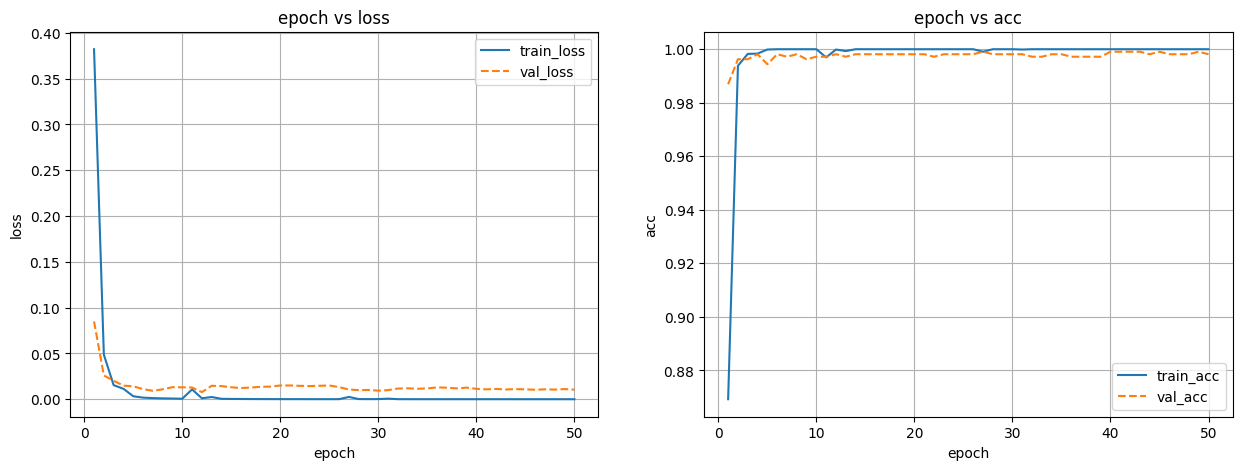

In [ ]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
# ax1.set_ylim([1000, 2000])
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== accuracy Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_epoch, list_train_acc, label='train_acc')
ax2.plot(list_epoch, list_val_acc, '--', label='val_acc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs acc')

plt.savefig(cur_dir+"matrix.png", dpi=400)

In [ ]:
for i in range(40, 50):
    print(list_epoch[i], list_train_loss[i], list_val_loss[i])

41 5.944186583119307e-05 0.010803724505430497
42 3.587652378297776e-05 0.011280927795151937
43 3.602986141146011e-05 0.010649754594834401
44 2.833688286528284e-05 0.011074139173688649
45 3.256302648314669e-05 0.010815172800422285
46 2.544125030214434e-05 0.010364686145177101
47 2.6054253386121975e-05 0.010813225755375123
48 2.509354298298661e-05 0.010550889995769993
49 2.4670917380863816e-05 0.01108616211633625
50 2.199936616220096e-05 0.010442765072832252


In [ ]:
for i in range(40, 50):
    print(list_epoch[i], list_train_acc[i], list_val_acc[i])

41 1.0 0.9990654205607477
42 1.0 0.9990654205607477
43 1.0 0.9990654205607477
44 1.0 0.9981308411214953
45 1.0 0.9990654205607477
46 1.0 0.9981308411214953
47 1.0 0.9981308411214953
48 1.0 0.9981308411214953
49 1.0 0.9990654205607477
50 1.0 0.9981308411214953


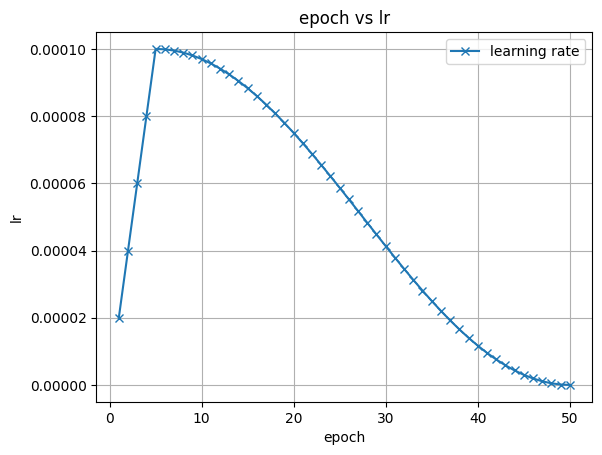

In [ ]:
plt.plot(list_epoch, list_lr, marker='x', label='learning rate')
plt.xlabel('epoch')
plt.ylabel('lr')
plt.grid()
plt.legend()
plt.title('epoch vs lr')
plt.legend()
plt.savefig(cur_dir+"lr.png", dpi=400)

# Eval

In [14]:
# 모델 평가
weight_path = "/content/drive/MyDrive/Colab_Notebooks/lpms/model_weight/weight_2024-06-18_16-08-02/42_3.587652378297776e-05.pth"
model_state_dict = torch.load(weight_path, map_location=device)
model.load_state_dict(model_state_dict)

model.eval()
correct = 0
total = 0
wrong = []
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device).view(-1,1)
        outputs = model(images)
        total += labels.size(0)
        correct += binary_accuracy(outputs, labels)

        rounded_preds = torch.round(outputs).cpu()
        labels = labels.cpu()
        wrong.append(images[np.where(rounded_preds != labels)])

accuracy = (correct / total)*100
print(accuracy)

100%|██████████| 34/34 [12:19<00:00, 21.74s/it]

99.90654205607477
